In [1]:
import torch
from torch import nn, optim
from torch.nn import DataParallel
import torch.nn.functional as F

# Nvidia Apex, fp16 and mixed precision training
from apex.fp16_utils import *

# Nvidia DALI, GPU Data Augmentation Library
from nvidia.dali.plugin.pytorch import DALIClassificationIterator

# Utilities
import random
import os
import pickle

# Output
import pandas as pd

# local import
from src.instrumentation import setup_logs, logspeed
from src.datafeed import *
from src.net_classic_arch import *
from src.training import train
from src.lr_finder import LRFinder


/usr/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
# np.random.seed(1337)
random.seed(1337)

In [3]:
TRAIN_DIR = './input/train'
TRAIN_FULL_IMG_LIST = './preprocessing/full_input.txt'
TRAIN_FOLD_IMG_LIST = './preprocessing/fold0_train.txt'
VAL_IMG_LIST = './preprocessing/fold0_val.txt'
LABEL_ENCODER_PATH = './preprocessing/labelEncoder.pickle'

TEST_DIR = './input/test'
TEST_IMG_LIST = './preprocessing/test_data.txt'
SUBMISSION_FILE = './input/sample_submission.csv'
OUT_DIR = './outputs'

NUM_THREADS = 18

EPOCHS = 25
BATCH_SIZE = 96          # This will be split onto all GPUs
VAL_BATCH_SIZE = 768     # We can use large batches when weights are frozen
REPORT_EVERY_N_BATCH = 5

PRETRAINED = False
UNFROZE_AT_EPOCH = 3
BATCH_FROZEN = 768       # We can use large batches when weights are frozen

# GPU data augmentation
# Note that it's probably better to do augmentation on CPU for compute intensive models
# So that you can maximize the batch size and training on GPU.
DATA_AUGMENT_USE_GPU = False
DATA_AUGMENT_GPU_DEVICE = 0

if PRETRAINED:
  # ImgNet normalization
  NORM_MEAN = [0.485, 0.456, 0.406]
  NORM_STD = [0.229, 0.224, 0.225]
else:
  # Dataset normalization parameter
  NORM_MEAN = [0.6073162, 0.5655911, 0.528621]
  NORM_STD = [0.26327327, 0.2652084, 0.27765632]

with open(LABEL_ENCODER_PATH, 'rb') as fh:
  LABEL_ENCODER = pickle.load(fh)

CRITERION = nn.CrossEntropyLoss
FINAL_ACTIVATION = lambda x: torch.softmax(x, dim=1)

In [4]:
model_family = 'resnet'
model_name = 'resnet101'
def gen_model_and_optimizer(data_parallel, weights = None):
  # Delay generating model, so that:
  #   - it can be collected if needed
  #   - DataParallel doesn't causes issue when loading a saved model
  model, feature_extractor, classifier = initialize_model(
    model_family = model_family,
    model_name = model_name,
    num_classes = LABEL_ENCODER.classes_.size,
    frozen_weights = PRETRAINED,
    use_pretrained = PRETRAINED,
    data_parallel = data_parallel,
    weights = weights
  )

  # TODO: cyclic momentum
  optimizer = optim.SGD(feature_extractor, lr = 0.01, momentum = 0.9)
  optimizer.add_param_group({
    'params': classifier,
    'lr': 0.001
  })

  # Make sure if there is a reference issue we see it ASAP
  del feature_extractor
  del classifier

  return model, optimizer

In [5]:
train_pipe = SimplePipeline(
    img_dir=TRAIN_DIR,
    img_list_path= TRAIN_FULL_IMG_LIST,
    batch_size=BATCH_SIZE,
    crop_size=224,
    ch_mean = NORM_MEAN,
    ch_std = NORM_STD,
    num_threads = NUM_THREADS,
    use_gpu = DATA_AUGMENT_USE_GPU,
    gpu_id = DATA_AUGMENT_GPU_DEVICE,
    seed = 1337
)
train_pipe.build()
train_loader = DALIClassificationIterator(train_pipe, size = train_pipe.epoch_size("Datafeed"))


In [6]:
model, optimizer = gen_model_and_optimizer(data_parallel = True)

In [7]:
criterion = CRITERION()

In [8]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

In [9]:
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


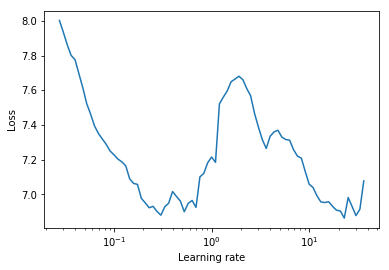

In [10]:
lr_finder.plot()